# Chapter 16. Generalized Linear Madness

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from jax import lax
from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey, shuffle
from jax.scipy.special import logsumexp

import numpyro
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

### Code 16.1

In [2]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

# scale observed variables
d["w"] = d.weight / d.weight.mean()
d["h"] = d.height / d.height.mean()

### Code 16.2

In [3]:
def model(h, w=None):
    p = numpyro.sample("p", dist.Beta(2, 18))
    k = numpyro.sample("k", dist.Exponential(0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = np.log(3.141593 * k * p ** 2 * h ** 3)
    numpyro.sample("w", dist.LogNormal(mu, sigma), obs=w)

m16_1 = MCMC(NUTS(model), 500, 500, num_chains=4)
m16_1.run(PRNGKey(0), d.h.values, d.w.values)

### Code 16.3

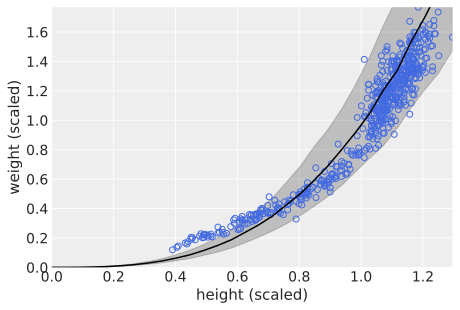

In [4]:
h_seq = np.linspace(0, d.h.max(), num=30)
w_sim = Predictive(model, m16_1.get_samples()).get_samples(
    PRNGKey(1), h=h_seq)["w"]
mu_mean = np.mean(w_sim, 0)
w_CI = np.percentile(w_sim, q=(5.5, 94.5), axis=0)
plt.plot(d.h, d.w, "o", c="royalblue", mfc="none")
plt.gca().set(xlim=(0, d.h.max()), ylim=(0, d.w.max()),
              xlabel="height (scaled)", ylabel="weight (scaled)")
plt.plot(h_seq, mu_mean, "k")
plt.fill_between(h_seq, w_CI[0], w_CI[1], color="k", alpha=0.2);

### Code 16.4

In [5]:
Boxes = pd.read_csv("../data/Boxes.csv", sep=";")
print_summary(dict(zip(Boxes.columns, Boxes.values.T)), 0.89, False)


                      mean       std    median      5.5%     94.5%     n_eff     r_hat
             age      8.03      2.50      8.00      5.00     12.00     13.16      1.10
         culture      3.75      1.96      3.00      1.00      6.00      5.27      1.27
          gender      1.51      0.50      2.00      1.00      2.00    288.12      1.00
  majority_first      0.48      0.50      0.00      0.00      1.00    798.44      1.00
               y      2.12      0.73      2.00      1.00      3.00    655.60      1.00



### Code 16.5

In [6]:
Boxes.y.value_counts(sort=False) / Boxes.y.shape[0]

1    0.211447
2    0.456280
3    0.332273
Name: y, dtype: float64

### Code 16.6

In [7]:
with numpyro.handlers.seed(rng_seed=7):
    N = 30  # number of children

    # half are random
    # sample from 1,2,3 at random for each
    y1 = np.array([1, 2, 3])[numpyro.sample(
        "y1", dist.Categorical(logits=np.ones(3)), sample_shape=(N // 2,))]

    # half follow majority
    y2 = np.repeat(2, N // 2)

    # combine and shuffle y1 and y2
    rng = numpyro.sample("rng", dist.PRNGIdentity())
    y = shuffle(rng, np.concatenate([y1, y2]))

    # count the 2s
    print(np.sum(y == 2) / N)

0.7


### Code 16.7

In [8]:
def Boxes_model(N, y, majority_first):
    # prior
    p = numpyro.sample("p", dist.Dirichlet(np.repeat(4, 5)))

    # probability of data
    phi = [None] * 5
    phi[0] = np.where(y == 2, 1, 0)  # majority
    phi[1] = np.where(y == 3, 1, 0)  # minority
    phi[2] = np.where(y == 1, 1, 0)  # maverick
    phi[3] = np.repeat(1.0 / 3.0, N)  # random
    phi[4] = np.where(majority_first == 1,  # follow first
                      np.where(y == 2, 1, 0),
                      np.where(y == 3, 1, 0))

    # compute log( p_s * Pr(y_i|s )
    for j in range(5):
        phi[j] = np.log(p[j]) + np.log(phi[j])
    # compute average log-probability of y
    logprob = logsumexp(np.stack(phi, axis=1), axis=1)
    numpyro.sample("logprob", dist.Delta(log_density=logprob), obs=0.)

### Code 16.8

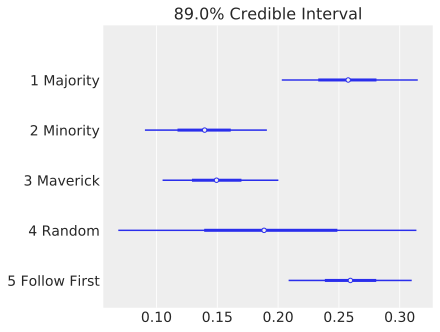

In [9]:
# prep data
dat_list = dict(N=Boxes.shape[0],
                y=Boxes.y.values,
                majority_first=Boxes.majority_first.values)

# run the sampler
m16_2 = MCMC(NUTS(Boxes_model), 1000, 1000, num_chains=3)
m16_2.run(PRNGKey(0), **dat_list)

# show marginal posterior for p
p_labels = ["1 Majority", "2 Minority", "3 Maverick",
            "4 Random", "5 Follow First"]
az.plot_forest(m16_2.get_samples(group_by_chain=True), combined=True,
               var_names="p", credible_interval=0.89)
plt.gca().set_yticklabels(p_labels[::-1]);

### Code 16.9

In [10]:
Panda_nuts = pd.read_csv("../data/Panda_nuts.csv", sep=";")

### Code 16.10

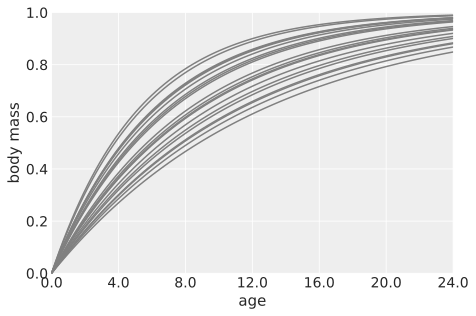

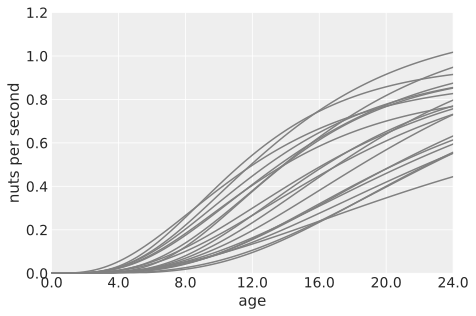

In [11]:
N = int(1e4)
phi = dist.LogNormal(np.log(1), 0.1).sample(PRNGKey(0), (N,))
k = dist.LogNormal(np.log(2), 0.25).sample(PRNGKey(1), (N,))
theta = dist.LogNormal(np.log(5), 0.25).sample(PRNGKey(2), (N,))

# relative grow curve
ax = plt.subplot(xlim=(0, 1.5), ylim=(0, 1), xlabel="age", ylabel="body mass")
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=np.round(at * Panda_nuts.age.max()))
x = np.linspace(0, 1.5, 101)
for i in range(20):
    plt.plot(x, 1 - np.exp(-k[i] * x), "gray", lw=1.5)
plt.show()

# implied rate of nut opening curve
ax = plt.subplot(xlim=(0, 1.5), ylim=(0, 1.2), xlabel="age",
                 ylabel="nuts per second")
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=np.round(at * Panda_nuts.age.max()))
x = np.linspace(0, 1.5, 101)
for i in range(20):
    plt.plot(x, phi[i] * (1 - np.exp(-k[i] * x)) ** theta[i], "gray", lw=1.5)

### Code 16.11

In [12]:
dat_list = dict(n=Panda_nuts.nuts_opened.values,
                age=Panda_nuts.age.values / Panda_nuts.age.max(),
                seconds=Panda_nuts.seconds.values)

def model(seconds, age, n):
    phi = numpyro.sample("phi", dist.LogNormal(np.log(1), 0.1))
    k = numpyro.sample("k", dist.LogNormal(np.log(2), 0.25))
    theta = numpyro.sample("theta", dist.LogNormal(np.log(5), 0.25))
    lambda_ = seconds * phi * (1 - np.exp(-k * age)) ** theta
    numpyro.sample("n", dist.Poisson(lambda_), obs=n)

m16_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m16_4.run(PRNGKey(0), **dat_list)

### Code 16.12

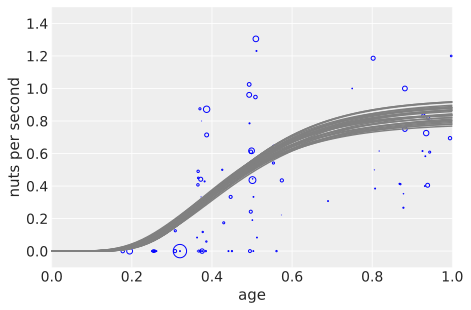

In [13]:
post = m16_4.get_samples()
plt.subplot(xlim=(0, 1), ylim=(-0.1, 1.5), xlabel="age",
            ylabel="nuts per second")
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=np.round(at * Panda_nuts.age.max()))

# raw data
pts = dat_list["n"] / dat_list["seconds"]
normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
point_size = normalize(dat_list["seconds"])
eps = (dat_list["age"][1:] - dat_list["age"][:-1]).max() / 5
jitter = eps * dist.Uniform(-1, 1).sample(PRNGKey(2), dat_list["age"].shape)
plt.scatter(dat_list["age"] + jitter, pts, s=(point_size * 3) ** 2 * 20,
            color="b", facecolors="none")

# 30 posterior curves
x = np.linspace(0, 1.5, 101)
for i in range(30):
    plt.plot(
        x,
        post["phi"][i] * (1 - np.exp(-post["k"][i] * x)) ** post["theta"][i],
        "gray")

### Code 16.13

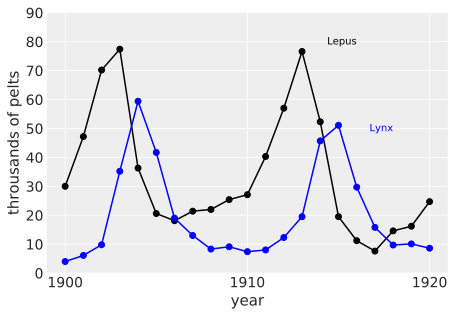

In [14]:
Lynx_Hare = pd.read_csv("../data/Lynx_Hare.csv", sep=";")
plt.plot(np.arange(1, 22), Lynx_Hare.iloc[:, 2], "ko-", lw=1.5)
plt.gca().set(ylim=(0, 90), xlabel="year", ylabel="throusands of pelts")
at = np.array([1, 11, 21])
plt.gca().set(xticks=at, xticklabels=Lynx_Hare.Year.iloc[at - 1])
plt.plot(np.arange(1, 22), Lynx_Hare.iloc[:, 1], "bo-", lw=1.5)
plt.annotate("Lepus", (17, 80), color="k", ha="right", va="center")
plt.annotate("Lynx", (19, 50), color="b", ha="right", va="center");

### Code 16.14

In [15]:
def sim_lynx_hare(n_steps, init, theta, dt=0.002):
    L0 = init[0]
    H0 = init[1]

    def f(val, i):
        H, L = val
        H_i = H + dt * H * (theta[0] - theta[1] * L)
        L_i = L + dt * L * (theta[2] * H - theta[3])
        return (H_i, L_i), (H_i, L_i)

    _, (H, L) = lax.scan(f, (H0, L0), np.arange(n_steps - 1))
    H = np.concatenate([np.expand_dims(H0, -1), H])
    L = np.concatenate([np.expand_dims(L0, -1), L])
    return np.stack([L, H], axis=1)

### Code 16.15

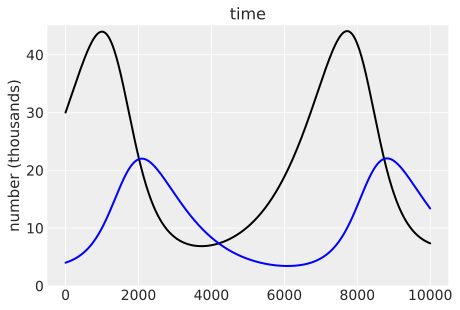

In [16]:
theta = np.array([0.5, 0.05, 0.025, 0.5])
z = sim_lynx_hare(int(1e4), Lynx_Hare.values[0, 1:3], theta)
plt.plot(z[:, 1], color='black', lw=2) # Hare population
plt.plot(z[:, 0], color='blue', lw=2) # Lynx population

plt.gca().set(ylim=(0, np.max(z[:, 1]) + 1),
              ylabel="number (thousands)", xlabel="")
plt.title("time");

### Code 16.16

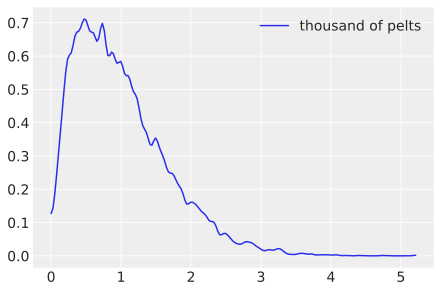

In [17]:
N = int(1e4)
Ht = int(1e4)
p = dist.Beta(2, 18).sample(PRNGKey(0), (N,))
h = dist.Binomial(Ht, p).sample(PRNGKey(1))
h = np.round(h / 1000, 2)
az.plot_kde(h, label="thousand of pelts", bw=1);

### Code 16.17

In [18]:
def dpop_dt(pop_init, t, bh, mh, ml, bl):
    """
    :param t: time
    :param pop_init: initial state {lynx, hares}
    :param theta: parameters
    """
    L = pop_init[0]
    H = pop_init[1]
    # differential equations
    dH_dt = (bh - mh * L) * H
    dL_dt = (bl * H - ml) * L
    return np.stack([dL_dt, dH_dt])

pop_odeint = build_odeint(dpop_dt, rtol=1e-5, atol=1e-3, mxstep=500)

def Lynx_Hare_model(N, pelts=None):
    """
    :param int N: number of measurement times
    :param pelts: measured populations
    """
    # priors
    # bh,mh,ml,bl
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(low=0., loc=np.tile(np.array([1, 0.05]), 2),
                             scale=np.tile(np.array([0.5, 0.05]), 2)))
    # measurement errors
    sigma = numpyro.sample("sigma", dist.Exponential(1), sample_shape=(2,))
    # initial population state
    pop_init = numpyro.sample("pop_init", dist.LogNormal(np.log(10), 1),
                            sample_shape=(2,))
    # trap rate
    p = numpyro.sample("p", dist.Beta(40, 200), sample_shape=(2,))

    # N including the first time (initial state)
    times_measured = np.arange(float(N))
    pop = pop_odeint(pop_init, times_measured, *theta)
    numpyro.sample("pop", dist.Delta(pop), obs=pop)

    # observation model
    # connect latent population state to observed pelts
    numpyro.sample("pelts", dist.LogNormal(np.log(pop * p), sigma), obs=pelts)

### Code 16.18

In [19]:
dat_list = dict(N=Lynx_Hare.shape[0], pelts=Lynx_Hare.values[:, 1:3])

m16_5 = MCMC(NUTS(Lynx_Hare_model, target_accept_prob=0.95),
             1000, 1000, num_chains=3)
m16_5.run(PRNGKey(0), **dat_list)

### Code 16.19

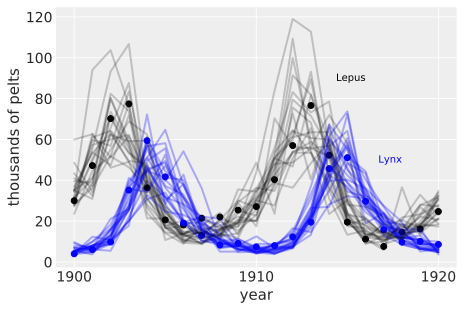

In [20]:
post = m16_5.get_samples()
predict = Predictive(m16_5.sampler.model, post, return_sites=["pelts", "pop"])
post = predict.get_samples(PRNGKey(1), dat_list["N"])
pelts = dat_list["pelts"]
plt.plot(range(1, 22), pelts[:, 1], "ko")
plt.gca().set(xlabel="year", ylabel="thousands of pelts")
at = np.array([1, 11, 21])
plt.gca().set(xticks=at, xticklabels=Lynx_Hare.Year.iloc[at - 1])
plt.plot(range(1, 22), pelts[:, 0], "bo")
# 21 time series from posterior
for s in range(21):
    plt.plot(range(1, 22), post["pelts"][s, :, 1], "k", alpha=0.2, lw=2)
    plt.plot(range(1, 22), post["pelts"][s, :, 0], "b", alpha=0.3, lw=2)
# text labels
plt.annotate("Lepus", (17, 90), color="k", ha="right", va="center")
plt.annotate("Lynx", (19, 50), color="b", ha="right", va="center");

### Code 16.20

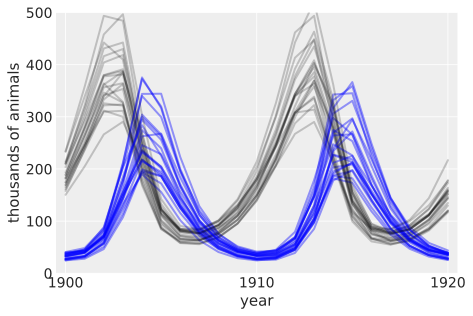

In [21]:
ax = plt.subplot(xlim=(0.5, 21.5), ylim=(0, 500), xlabel="year",
                 ylabel="thousands of animals")
at = np.array([1, 11, 21])
ax.set(xticks=at, xticklabels=Lynx_Hare.Year.iloc[at - 1])
for s in range(21):
    ax.plot(np.arange(1, 22), post["pop"][s, :, 1], "k", lw=2, alpha=0.2)
    ax.plot(np.arange(1, 22), post["pop"][s, :, 0], "b", lw=2, alpha=0.4)

### Code 16.21

In [22]:
Lynx_Hare = pd.read_csv("../data/Lynx_Hare.csv", sep=";")
dat_ar1 = dict(L=Lynx_Hare.Lynx.values[1:],
               L_lag1=Lynx_Hare.Lynx.values[:-1],
               H=Lynx_Hare.Hare.values[1:],
               H_lag1=Lynx_Hare.Lynx.values[:-1])